In [ ]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the Data
df = pd.read_csv("/content/drive/MyDrive/infosys_financials_2021_2025_csv.csv")

print("Data Shape:", df.shape)
display(df.head())

Data Shape: (18, 6)


,Quarter,Revenue,Operating_Income,Net_Income,Operating_Expenses,Profit_Margin
0,2021-Q1,23665,5365,4233,18300,17.9
1,2021-Q2,24570,6228,4845,18342,19.7
2,2021-Q3,25927,6589,5197,19338,20.1
3,2021-Q4,26311,6972,5078,19339,19.3
4,2022-Q1,27896,6603,5195,21293,18.6


In [ ]:
# Data Cleaning
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Try to detect a date or quarter column
date_col = [col for col in df.columns if "date" in col.lower() or "quarter" in col.lower()]
if len(date_col) == 0:
    # If not found, create a synthetic date index (assuming quarterly data)
    df['quarter_end'] = pd.date_range(start='2021-06-30', periods=len(df), freq='Q')
    date_col = ['quarter_end']

df[date_col[0]] = pd.to_datetime(df[date_col[0]], errors='coerce')

/tmp/ipython-input-2995994017.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col[0]] = pd.to_datetime(df[date_col[0]], errors='coerce')


In [ ]:
# Clean numeric columns (₹, Rs, commas)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].replace('[₹,Rs ]', '', regex=True)
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [ ]:
# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

/tmp/ipython-input-2094442860.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2094442860.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [ ]:
# Add Indian Financial Year & Quarter columns
def indian_financial_quarter(date):
    m = date.month
    if m in [4,5,6]:
        return f"Q1 FY{date.year}-{str(date.year+1)[-2:]}"
    elif m in [7,8,9]:
        return f"Q2 FY{date.year}-{str(date.year+1)[-2:]}"
    elif m in [10,11,12]:
        return f"Q3 FY{date.year}-{str(date.year+1)[-2:]}"
    else:  # Jan–Mar
        return f"Q4 FY{date.year-1}-{str(date.year)[-2:]}"

df['financial_quarter'] = df[date_col[0]].apply(indian_financial_quarter)
df['financial_quarter'] = pd.Categorical(df['financial_quarter'], ordered=True)

display(df[['financial_quarter']].head())


,financial_quarter
0,Q4 FY2020-21
1,Q1 FY2021-22
2,Q2 FY2021-22
3,Q3 FY2021-22
4,Q4 FY2021-22


In [ ]:
#Descriptive Statistics
display(df.describe(include='all'))

,quarter,revenue,operating_income,net_income,operating_expenses,profit_margin,financial_quarter
count,18,18.000000,18.000000,18.000000,18.000000,18.000000,18
unique,NaN,NaN,NaN,NaN,NaN,NaN,18
top,NaN,NaN,NaN,NaN,NaN,NaN,Q1 FY2021-22
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,2023-02-15 01:20:00,33996.166667,7465.722222,5817.833333,26530.444444,17.327778,NaN
min,2021-01-01 00:00:00,23665.000000,5365.000000,4233.000000,18300.000000,15.700000,NaN
25%,2022-01-23 12:00:00,28322.500000,6986.750000,5253.000000,21612.500000,16.075000,NaN
50%,2023-02-15 00:00:00,35504.000000,7584.500000,5945.000000,27955.000000,16.850000,NaN
75%,2024-03-09 06:00:00,38798.000000,7895.250000,6191.000000,30870.500000,18.275000,NaN
max,2025-04-01 00:00:00,44490.000000,8935.000000,7364.000000,35555.000000,20.100000,NaN


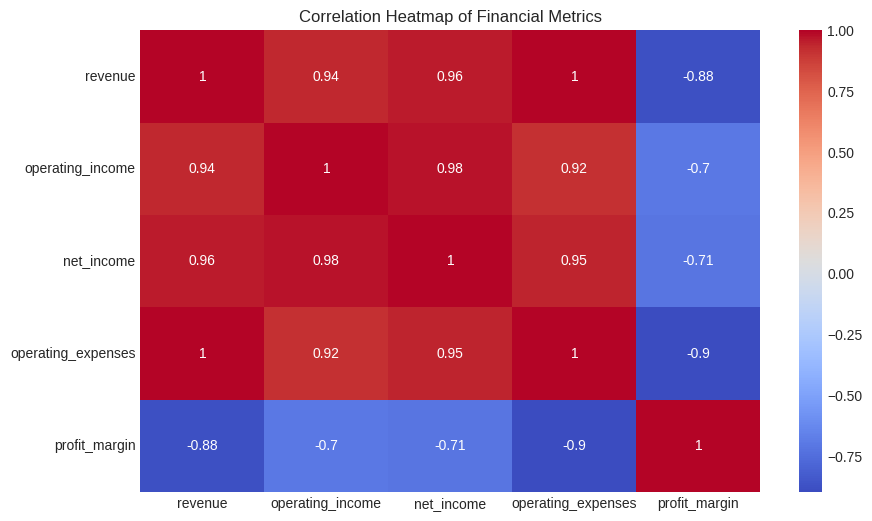

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Financial Metrics")
plt.show()

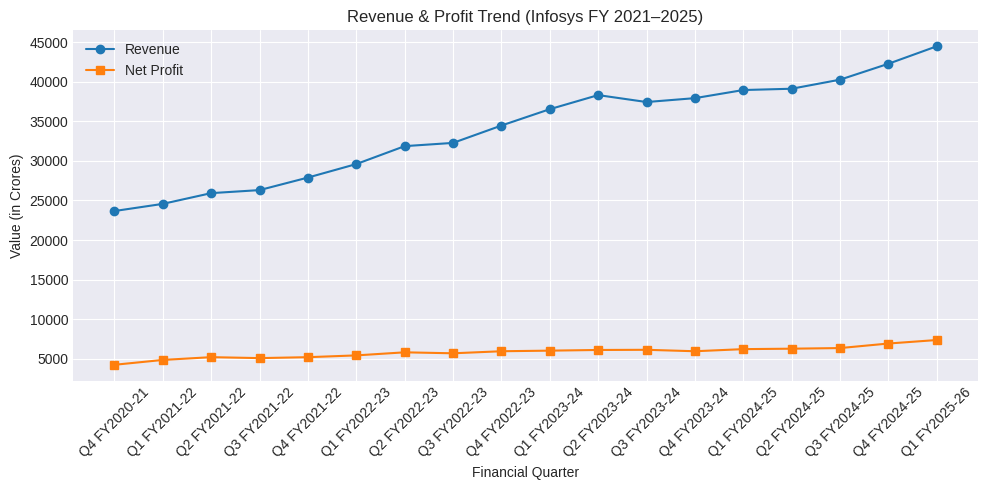

In [ ]:
#Revenue & Profit Trends (Matplotlib + Plotly)

plt.figure(figsize=(10, 5))
plt.plot(df['financial_quarter'], df['revenue'], label='Revenue', marker='o')
plt.plot(df['financial_quarter'], df['net_income'], label='Net Profit', marker='s')
plt.xticks(rotation=45)
plt.title("Revenue & Profit Trend (Infosys FY 2021–2025)")
plt.xlabel("Financial Quarter")
plt.ylabel("Value (in Crores)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Interactive Plotly version
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['financial_quarter'], y=df['revenue'], mode='lines+markers', name='Revenue'))
fig.add_trace(go.Scatter(x=df['financial_quarter'], y=df['net_income'], mode='lines+markers', name='Net Profit'))
fig.update_layout(title="Infosys Financial Trend (FY2021–FY2025)",
                  xaxis_title="Financial Quarter",
                  yaxis_title="Value (in Crores)",
                  template='plotly_dark')
fig.show()

In [ ]:
# Growth Rate Calculations
df['revenue_growth_%'] = df['revenue'].pct_change() * 100
df['profit_growth_%'] = df['net_income'].pct_change() * 100

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill only numeric columns with 0
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Display the results
display(df[['financial_quarter', 'revenue_growth_%', 'profit_growth_%']].head())


,financial_quarter,revenue_growth_%,profit_growth_%
0,Q4 FY2020-21,0.000000,0.000000
1,Q1 FY2021-22,3.824213,14.457831
2,Q2 FY2021-22,5.522996,7.265222
3,Q3 FY2021-22,1.481081,-2.289783
4,Q4 FY2021-22,6.024096,2.304057


In [ ]:
# Simple Forecast
# --------------------------------------------------------------
x = np.arange(len(df))
y = df['revenue'].values

coeffs = np.polyfit(x, y, 1)
trend = np.poly1d(coeffs)

# Forecast next 3 quarters
future_x = np.arange(len(df), len(df) + 3)
future_y = trend(future_x)

# Generate next 3 FY quarters
last_date = df[date_col[0]].iloc[-1]
future_dates = pd.date_range(last_date + pd.offsets.QuarterEnd(), periods=3, freq='Q')
future_quarters = [indian_financial_quarter(d) for d in future_dates]

forecast_df = pd.DataFrame({
    'financial_quarter': future_quarters,
    'predicted_revenue': future_y
})
display(forecast_df)

/tmp/ipython-input-2690780601.py:15: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



,financial_quarter,predicted_revenue
0,Q1 FY2025-26,45299.627451
1,Q2 FY2025-26,46489.465428
2,Q3 FY2025-26,47679.303406


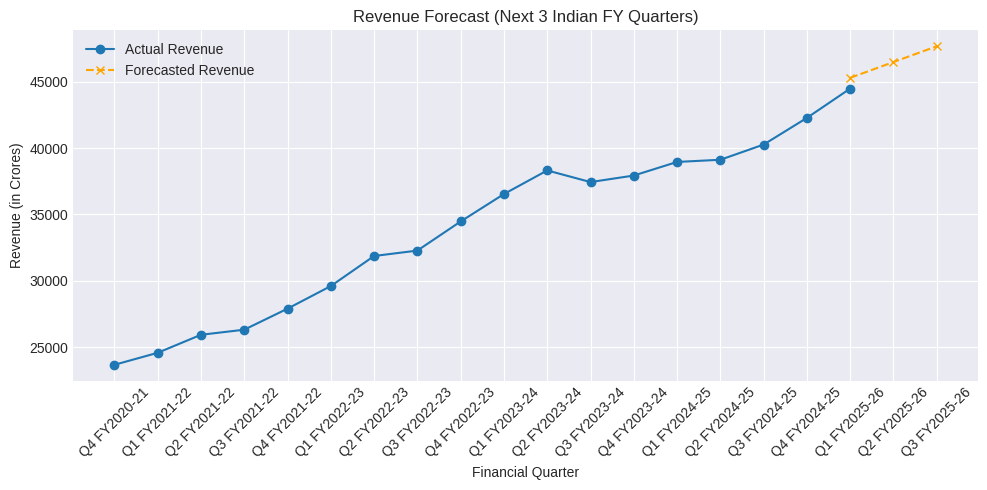

In [ ]:
# Plot Actual vs Forecasted Revenue
plt.figure(figsize=(10, 5))
plt.plot(df['financial_quarter'], df['revenue'], label='Actual Revenue', marker='o')
plt.plot(forecast_df['financial_quarter'], forecast_df['predicted_revenue'], label='Forecasted Revenue', marker='x', linestyle='--', color='orange')
plt.xticks(rotation=45)
plt.title("Revenue Forecast (Next 3 Indian FY Quarters)")
plt.xlabel("Financial Quarter")
plt.ylabel("Revenue (in Crores)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['financial_quarter'], y=df['revenue'], mode='lines+markers', name='Actual Revenue'))
fig.add_trace(go.Scatter(x=forecast_df['financial_quarter'], y=forecast_df['predicted_revenue'],
                         mode='lines+markers', name='Forecasted Revenue', line=dict(dash='dash', color='orange')))
fig.update_layout(title="Interactive Revenue Forecast (Next 3 Quarters - Indian FY)",
                  xaxis_title="Financial Quarter",
                  yaxis_title="Revenue (in Crores)",
                  template="plotly_dark")
fig.show()

In [22]:
df.to_csv("infosys_cleaned_fy.csv", index=False)
forecast_df.to_csv("infosys_forecast_fy.csv", index=False)
print("✅ Files saved: infosys_cleaned_fy.csv & infosys_forecast_fy.csv")

✅ Files saved: infosys_cleaned_fy.csv & infosys_forecast_fy.csv
